# Veri Seti

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

print("🔽 Veri seti yükleniyor...")
df = pd.read_csv("YSA2.csv", sep=";", encoding="ISO-8859-9")
print(f"✅ Veri seti boyutu: {df.shape}\n")

print("🔎 İlk 5 satır:")
print(df.head(), "\n")

print("📊 Veri seti hakkında bilgi:")
print(df.info(), "\n")

🔽 Veri seti yükleniyor...
✅ Veri seti boyutu: (30457, 15)

🔎 İlk 5 satır:
   No     Deprem Kodu Olus tarihi Olus zamani    Enlem   Boylam  Der(km)   xM  \
0       1    2,03E+13  31.10.2025    20:28:47  391.425  281.988      9.5  3.1   
1       2    2,03E+13  31.10.2025    19:58:58  391.495  282.278     12.1  2.6   
2       3    2,03E+13  31.10.2025    17:32:57  391.678  282.337     12.4  2.5   
3       4    2,03E+13  31.10.2025    17:31:06  391.370  281.950      5.7  3.6   
4       5    2,03E+13  31.10.2025    15:52:22  391.730  281.452     14.8  3.0   

   MD   ML   Mw  Ms  Mb Tip                                                Yer  
0   0  3.1  3.0   0   0  Ke    AKTAS-SINDIRGI (BALIKESIR) [South East  1.9 km]  
1   0  2.6  0.0   0   0  Ke  BAYRAKLI-SINDIRGI (BALIKESIR) [South West  1.4...  
2   0  2.5  0.0   0   0  Ke  BAYRAKLI-SINDIRGI (BALIKESIR) [North West  1.8...  
3   0  3.6  3.5   0   0  Ke          AKTAS-SINDIRGI (BALIKESIR) [South 2.5 km]  
4   0  3.0  0.0   0   0  Ke       

# 2. Aşama: Veri Standardizasyonu

In [ ]:
import re #Yer sütunundaki veriler için
import numpy as np
import pandas as pd

##Standardizasyon İşlemleri(Veri Normalleştirme)
#########1.ADIM: Gereksiz sütunları modelin  kafası karışmaması için kaldırma
# Kaldırılacak sütunlar
cols_to_drop = ['MD', 'ML', 'Mw', 'Ms', 'Mb', 'Tip']

# Silme işlemi
df.drop(columns=cols_to_drop, axis=1, inplace=True, errors='ignore')

print(f"🗑️ Kaldırılan sütunlar (eğer varsa): {', '.join(cols_to_drop)}")


#########2.ADIM: Zaman Damgası
# Tarih ve Saat sütunlarını birleştirip datetime tipine çevirme
df['datetime'] = pd.to_datetime(df['Olus tarihi'] + ' ' + df['Olus zamani'], dayfirst=True)

# Modelin mevsimsel veya günlük döngüleri öğrenebilmesi için parçalara ayırıyoruz -----> GEREK VAR MI?
df['Ay'] = df['datetime'].dt.month
df['Saat'] = df['datetime'].dt.hour
df['HaftaninGunu'] = df['datetime'].dt.dayofweek # 0=Pazartesi, 6=Pazar

# Eski metin tabanlı tarih sütunlarını silme
df.drop(['Olus tarihi', 'Olus zamani', 'datetime'], axis=1, inplace=True)


#########3.ADIM: Yer sütunundan anlamlı bilgiler çıkarma (Feature Extraction)
# Mesafe bilgisini Regex ile çekme
df['Mesafe_km'] = df['Yer'].str.extract(r'(\d+\.\d+) km').astype(float)

# Şehir bilgisini çekme
df['Sehir'] = df['Yer'].str.extract(r'\((.*?)\)')

# Kaç tane boş değer oluştuğunu kontrolü
print("Eksik veri sayıları:\n", df.isnull().sum())

# Eğer Mesafe_km boşsa, o bölgedeki ortalama mesafeyle doldurulacaak
df['Mesafe_km'] = df['Mesafe_km'].fillna(df['Mesafe_km'].median())

# Eğer Sehir boşsa 'BILINMEYEN' olarak işaretlenecek
df['Sehir'] = df['Sehir'].fillna('BILINMEYEN')



🗑️ Kaldırılan sütunlar (eğer varsa): MD, ML, Mw, Ms, Mb, Tip
Eksik veri sayıları:
 No                 0
Deprem Kodu        0
Enlem              0
Boylam             0
Der(km)            0
xM                 0
Yer                0
Ay                 0
Saat               0
HaftaninGunu       0
Mesafe_km       7970
Sehir           3730
dtype: int64


## **Korelasyon** **Matrisi**

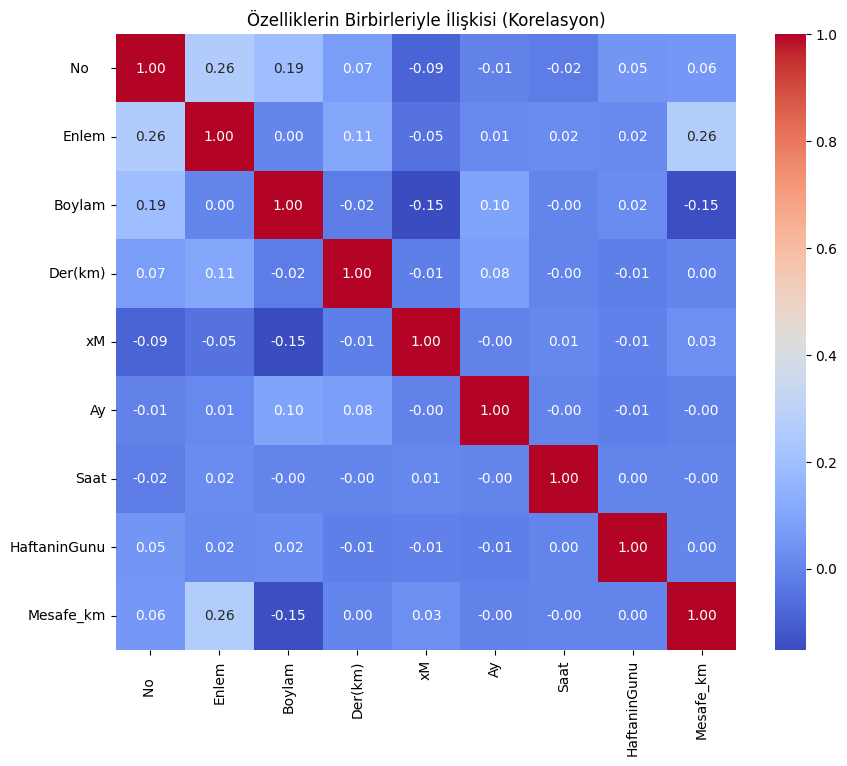

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece sayısal sütunlar arasındaki ilişkisinin hesaplanması
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Isı haritası (Heatmap) oluşturma
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Özelliklerin Birbirleriyle İlişkisi (Korelasyon)")
plt.show()

# Proje denemesi 1.Deprem Risk Haritası ve Anomali Tespiti

DataFrame head:
   No Deprem Kodu    Enlem   Boylam  Der(km)   xM  \
0   1    2,03E+13  391.425  281.988      9.5  3.1   
1   2    2,03E+13  391.495  282.278     12.1  2.6   
2   3    2,03E+13  391.678  282.337     12.4  2.5   
3   4    2,03E+13  391.370  281.950      5.7  3.6   
4   5    2,03E+13  391.730  281.452     14.8  3.0   

                                                 Yer  Ay  Saat  HaftaninGunu  \
0    AKTAS-SINDIRGI (BALIKESIR) [South East  1.9 km]  10    20             4   
1  BAYRAKLI-SINDIRGI (BALIKESIR) [South West  1.4...  10    19             4   
2  BAYRAKLI-SINDIRGI (BALIKESIR) [North West  1.8...  10    17             4   
3          AKTAS-SINDIRGI (BALIKESIR) [South 2.5 km]  10    17             4   
4       SINANDEDE-SINDIRGI (BALIKESIR) [West 0.5 km]  10    15             4   

   Mesafe_km      Sehir  
0        1.9  BALIKESIR  
1        1.4  BALIKESIR  
2        1.8  BALIKESIR  
3        2.5  BALIKESIR  
4        0.5  BALIKESIR  

Risk Haritası oluşturuldu (

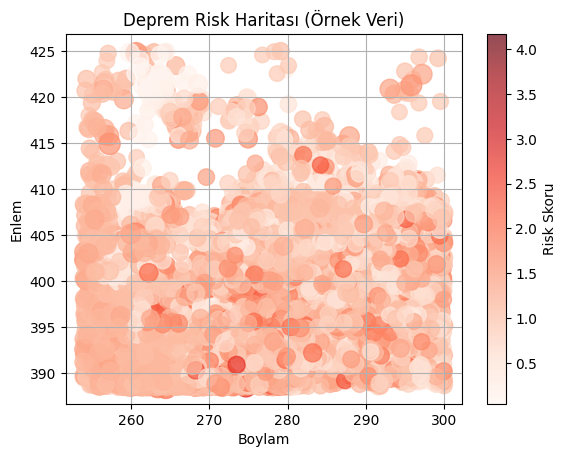

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import io

df.columns = df.columns.str.strip()

print("DataFrame head:")
print(df.head())

# Risk skoru
df['Risk_Score'] = df['xM'] / (df['Mesafe_km'] + 1)

# Scatter plot (risk haritası, basit versiyon)
fig, ax = plt.subplots()
scatter = ax.scatter(df['Boylam'], df['Enlem'], s=df['xM']*50, c=df['Risk_Score'], cmap='Reds', alpha=0.7)
ax.set_title('Deprem Risk Haritası (Örnek Veri)')
ax.set_xlabel('Boylam')
ax.set_ylabel('Enlem')
plt.colorbar(scatter, label='Risk Skoru')
plt.grid(True)

img_buf = io.BytesIO()
fig.savefig(img_buf, format='png')
img_buf.seek(0)
print("\nRisk Haritası oluşturuldu (scatter plot).")

# Anomali tespiti iptal, yapılmayacak.

GeoPandas

Filtre öncesi toplam deprem sayısı: 30457
Filtre sonrası (M > 3.0) kalan deprem sayısı: 6384
Kalan minimum magnitüd: 3.10 (maksimum: 6.80)


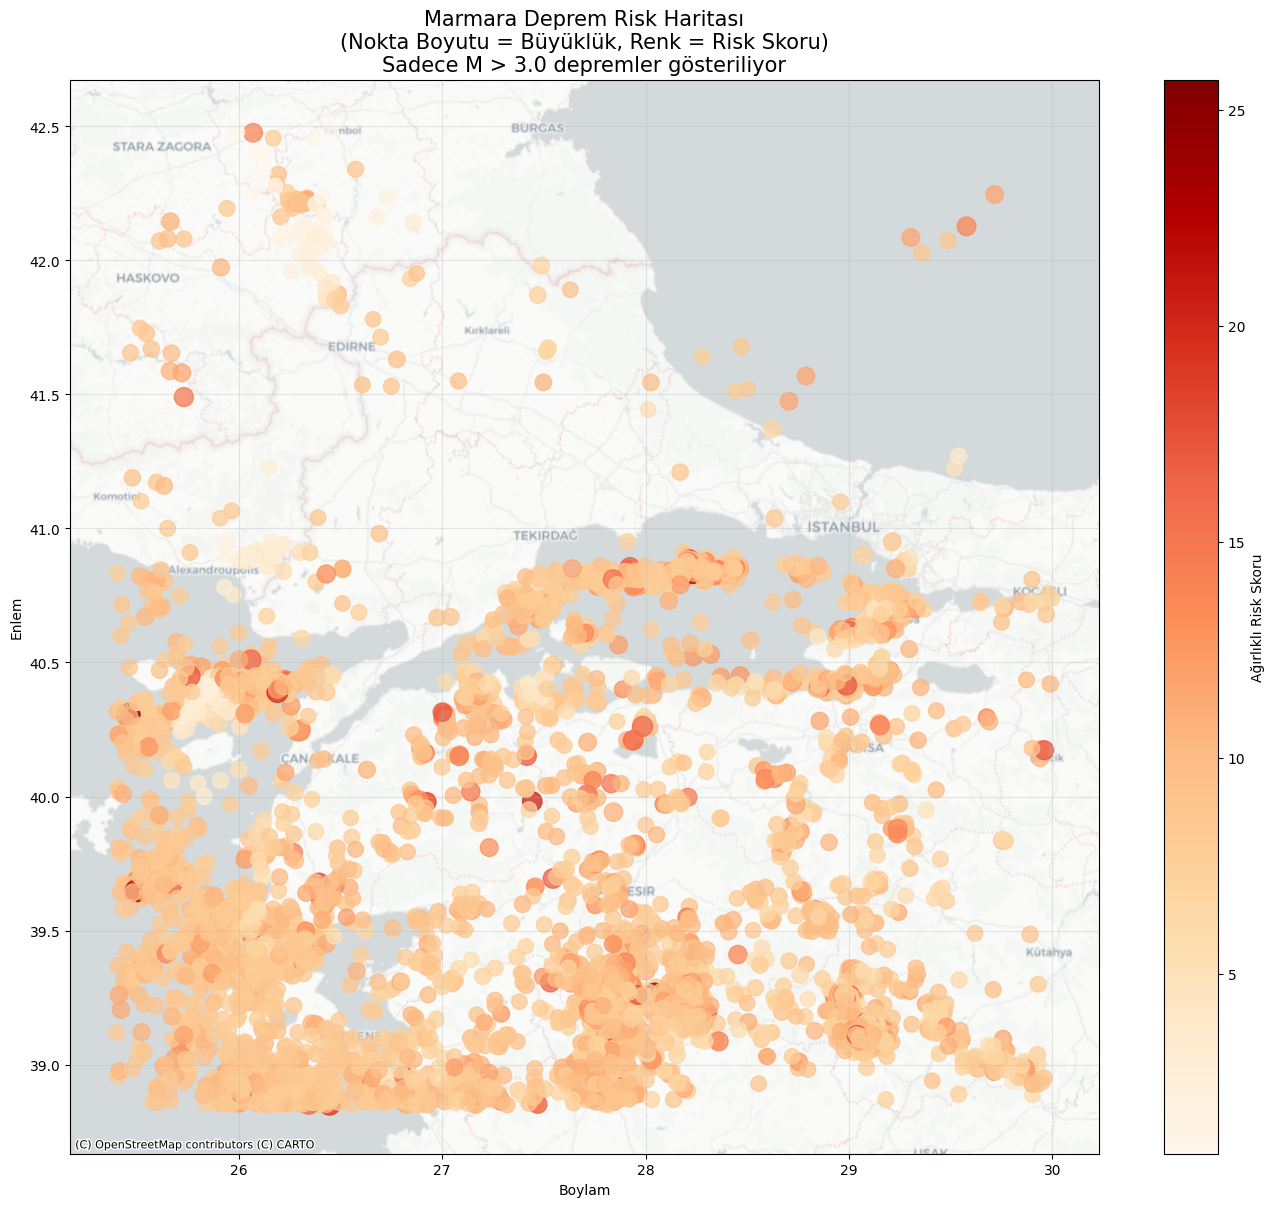

In [ ]:
# 'contextily' kütüphanesi eksik olduğu için yükleniyor.
!pip install contextily

import pandas as pd
import geopandas as gpd    # --->Lokal üzerinde GeoPandas için Miniconda kurulumu gerekiyor
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

# ────────────────────────────────────────────────
# 1. Veriyi okur ve GeoDataFrame'e çevirir
# ────────────────────────────────────────────────
# df = pd.read_csv('YSA2.csv', sep=";", encoding="ISO-8859-9")  # Eğer df henüz tanımlı değilse bunu ekle!
# Yukarıdaki kod satırlarından veri seti başlığında tanımlandı!!!
# Yularıdaki kod blokları çalıştırılmadan bu kod satırı çalıştırılırsa hata verir

# Sütun isimlerini temizler
df.columns = df.columns.str.strip()

# Koordinatların standart coğrafi aralıkta olmadığını varsayarak düzeltme işlemleri yapılmalı
# Koordinatların yanlış ölçeklenmiş olduğu varsayımına dayanmakta --> GEREKLİ Mİ?
if df['Enlem'].max() > 90 or df['Enlem'].min() < -90 or \
   df['Boylam'].max() > 180 or df['Boylam'].min() < -180:
    print("Enlem veya Boylam değerleri standart coğrafi aralığın dışında. Normalizasyon uygulanıyor...")
    df['Enlem'] = df['Enlem'] / 10.0
    df['Boylam'] = df['Boylam'] / 10.0
    print(f"Normalleştirilmiş Boylam min: {df['Boylam'].min()}, Normalleştirilmiş Boylam max: {df['Boylam'].max()}")
    print(f"Normalleştirilmiş Enlem min: {df['Enlem'].min()}, Normalleştirilmiş Enlem max: {df['Enlem'].max()}")

# Geometry oluştur (Boylam → x, Enlem → y)
geometry = [Point(xy) for xy in zip(df['Boylam'], df['Enlem'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# ────────────────────────────────────────────────
# 3 ve altı depremleri filtrele (M ≤ 3.0 olanları çıkar)
# ────────────────────────────────────────────────
esik = 3.0
gdf_original_len = len(gdf)
gdf = gdf[gdf['xM'] > esik].copy()

print(f"Filtre öncesi toplam deprem sayısı: {gdf_original_len}")
print(f"Filtre sonrası (M > {esik}) kalan deprem sayısı: {len(gdf)}")
print(f"Kalan minimum magnitüd: {gdf['xM'].min():.2f} (maksimum: {gdf['xM'].max():.2f})")

# ────────────────────────────────────────────────
# 2. Risk Skoru Hesapla (filtre edilmiş gdf ile)
# ────────────────────────────────────────────────
gdf['Risk_Score_Basic'] = gdf['xM'] / (gdf['Mesafe_km'] + 1)          # yüksek M + yakın = yüksek risk

# Daha gelişmiş skor (logaritmik + ağırlık)
gdf['Risk_Score_Weighted'] = (gdf['xM'] ** 1.5) / (gdf['Mesafe_km'] + 5) * 10

# ────────────────────────────────────────────────
# 3. Harita 1: Nokta tabanlı Risk Haritası (yeni eşik ile çizilecek)
# ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 12))

gdf.plot(
    ax=ax,
    column='Risk_Score_Weighted',       # renklendirme
    cmap='OrRd',                        # turuncu-kırmızı tonlar
    markersize=gdf['xM'] * 40,          # büyüklük = nokta boyutu
    alpha=0.75,
    legend=True,
    legend_kwds={'label': "Ağırlıklı Risk Skoru", 'orientation': "vertical"}
)

ax.set_title(f'Marmara Deprem Risk Haritası\n(Nokta Boyutu = Büyüklük, Renk = Risk Skoru)\nSadece M > {esik} depremler gösteriliyor', fontsize=15)
ax.set_xlabel('Boylam')
ax.set_ylabel('Enlem')

# Arka plan haritasının eklenmesi
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()